[View in Colaboratory](https://colab.research.google.com/github/pabloiarriola/lab3-DataScience/blob/master/DeepLearning.ipynb)

# Laboratorio 3



link para compartir: https://drive.google.com/drive/folders/18C7EzsX9LetIhz9WuUV4Bd6yAeeaubMz?usp=sharing 

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt

In [0]:
# Parametros
LEARNING_RATE = 0.001
TRAINING_EPOCHS = 3000
BATCH_SIZE = 100
DISPLAY_STEP = 10
DROPOUT_CONV = 0.8
DROPOUT_HIDDEN = 0.6
VALIDATION_SIZE = 2000      # Set to 0 to train on all available data

In [0]:
!pip install -U -q PyDrive ## you will have install for every colab session
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [11]:
file_list = drive.ListFile({'q': "'18C7EzsX9LetIhz9WuUV4Bd6yAeeaubMz' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: DeepLearning.ipynb, id: 1DK9HGJwT4ax6NsA2cUVr1Hlz_OsI2T0l
title: Github.ipynb, id: 1KYm-XUsbyn-RFeANDKDf1FrkMqCmFvTG
title: train.csv, id: 1PNwiiiKC8ziiCnlOYE6EPMNWC0BDdkuH
title: test.csv, id: 1vdBec1A_SCu4v0r_SRqd5oqPVAkUYYyC
title: sample_submission.csv, id: 1Zq7yOsJeedmfqmK2srbJU0rMvFkQEK_Q


In [0]:
test = drive.CreateFile({'id': '1vdBec1A_SCu4v0r_SRqd5oqPVAkUYYyC'})
test.GetContentFile('test.csv')
sample = drive.CreateFile({'id': '1Zq7yOsJeedmfqmK2srbJU0rMvFkQEK_Q'})
sample.GetContentFile('sample.csv')
train = drive.CreateFile({'id': '1PNwiiiKC8ziiCnlOYE6EPMNWC0BDdkuH'})
train.GetContentFile('train.csv')

## Análisis Exploratorio


Lo que sabemos: <br>
*  Cada imagen tiene 28 píxeles de altura y 28 píxeles de ancho
*  784 píxeles en total
*  Valor entre 0 y 255 escala gris (0 es el mas blanco)
* La imagen son letras
* train.csv tiene 785 porque tiene una columna extra "etiqueta" con el digito del dibujo

---
Cargamos los datos

In [0]:
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample.csv')
train = pd.read_csv('train.csv')

---
Miramos que tipo son los valores de pixeles

In [33]:
test.dtypes.head()

pixel0    int64
pixel1    int64
pixel2    int64
pixel3    int64
pixel4    int64
dtype: object

In [34]:
test.shape[1]

784

Encontramos que tiene 784 variables que es exactmanete como nos direon la informacion y que estan trabajando con enteros

In [36]:
train.dtypes.head()

label     int64
pixel0    int64
pixel1    int64
pixel2    int64
pixel3    int64
dtype: object

In [42]:
train.shape[1]

785

In [54]:
train[['label']].describe()

,label
count,42000.000000
mean,4.456643
std,2.887730
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


Sesgado : label    0.026479
dtype: float64


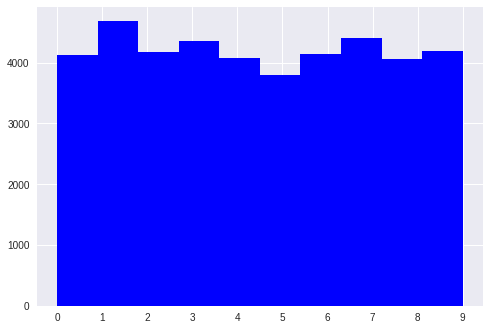

In [88]:
print ("Sesgado :", (train[['label']].skew()))
plt.hist(train[['label']], color='blue')
plt.show()

Aqui encontramos que hay una columna extra pero se llama *label*<br>Label tiene el valor de 0 a 9 representando el dibujo. El promedio siendo 4.456<br>Para no confundirnos vamos a **separar** el label del dataset


## Deep Learning

In [0]:
import numpy as np
import pandas as pd

import tensorflow as tf

# Parameters
LEARNING_RATE = 0.001
TRAINING_EPOCHS = 3000
BATCH_SIZE = 100
DISPLAY_STEP = 10
DROPOUT_CONV = 0.8
DROPOUT_HIDDEN = 0.6
VALIDATION_SIZE = 2000      # Set to 0 to train on all available data


In [0]:
data = pd.read_csv('train.csv')

In [0]:
label = train[['label']].values.ravel()

In [29]:
label

array([1, 0, 1, ..., 7, 6, 9])

Lo volvimos un array para poder manipularlo con tenserflow<br>
Tambien sacamos los diferentes variedades de labels que tienen

In [0]:
NumDelabels = np.unique(label).shape[0]

In [31]:
NumDelabels

10

Ahora vamos a separar los dibujos y ponerlos en un array

In [0]:
dibujo = train.iloc[:,1:].values
dibujo = dibujo.astype(np.float)

In [33]:
dibujo

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Por simplisidad lo queremos volver en un arreglo pero con la etiqueta como etiqueta

```
0: [0,0,0,0,0,0,0,...,0]
1: [0,0,0,0,0,0,0,...,0]
2: [0,0,0,0,0,0,0,...,0]
3: [0,0,0,0,0,0,0,...,0]
4: [0,0,0,0,0,0,0,...,0]
5: [0,0,0,0,0,0,0,...,0]
```



In [0]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [0]:
labels = dense_to_one_hot(label, NumDelabels)
labels = labels.astype(np.uint8)

Normalizamos los datos de 0 - 255 ahora va a ser de 0.0 a 1.0

In [0]:
dibujo = np.multiply(images, 1.0 / 255.0)
NumDedibujo = dibujo.shape[1]
dibujoRow = dibujoCol = np.ceil(np.sqrt(NumDedibujo)).astype(np.uint8)

---
Analizando **sample**:

In [36]:
print('(filas, columnas)')
sample.shape

(filas, columnas)


(28000, 2)

In [37]:
sample.dtypes

ImageId    int64
Label      int64
dtype: object

Tiene dos variables y 28000 registros. Los dos son enteros

In [38]:
sample.describe()

,ImageId,Label
count,28000.000000,28000.0
mean,14000.500000,0.0
std,8083.048105,0.0
min,1.000000,0.0
25%,7000.750000,0.0
50%,14000.500000,0.0
75%,21000.250000,0.0
max,28000.000000,0.0


Label siempre va a tener el valor de 0 ya que el valor máximo y mínimo encontrado es 0. <br>
Image Id parece ser el id de la imagen que es un contador que empieza en 1 y termina en 28 mil.

## Otro Algoritmo

Algoritmo escogido en: http://yann.lecun.com/exdb/mnist/ 

Graficas para usar despues

```
x=seasonSummary['2P']
y=seasonSummary['eff']
plt.scatter(x, y)
plt.xlabel('2P')
plt.ylabel('eff')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()


print ("Sesgado :", train.skew())
plt.hist(np.log(train), color='blue')
plt.show()
```

